Bank Churn prediction
Context:
Businesses like banks which provide service have to worry about problem of 'Customer Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

Objective:
Let us consider you are working as Data scientist with the bank and you need to build a neural network based classifier that can determine whether a customer will leave the bank or not in the next 6 months.

Data Dictionary:
The case study is from an open-source dataset from Kaggle.The dataset contains 10,000 sample points with 14 distinct features as follows:

CustomerId: Unique ID which is assigned to each customer

Surname: Last name of the customer

CreditScore: It defines the credit history of the customer.

Geography: A customer’s location

Gender: It defines the Gender of the customer

Age: Age of the customer

Tenure: Number of years for which the customer has been with the bank

NumOfProducts: refers to the number of products that a customer has purchased through the bank.

Balance: Account balance

HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.

EstimatedSalary: Estimated salary

isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

Excited : whether or not the customer left the bank within six month. It can take two values

0=No ( Customer did not leave the bank ) 1=Yes ( Customer left the bank )



In [10]:
#Load the file

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/Users/sakshamgrover/Codes/newcode/ML Int/bank_churn.csv')

print(df.describe())
print(df.columns.tolist())
print(df.isnull().sum())
print(df.tail())
print([(col, df[col].dtype) for col in df.columns])
print(df.isnull().sum())
print(df['Exited'].value_counts(normalize=True))   # class balance



         RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000     

From this we can start preprocessing by labeling out the 14 features based on whether they are numerical, categorical, or target.
After selecting numerical and categorical features, we pick the X and y target and drop unncecessary columns which will not contribute to the objective of finding customer churn. The class imbalance for customers exiting vs not exiting is that almost 80% of customers dont, meanwhile the 20% do which will be the main focus since the objective is to keep the customers from exiting

In [31]:
y = df['Exited']
X = df.drop(columns=['Exited', 'CustomerId', 'Surname', 'RowNumber'])

numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

After selecting target and features, the data can be traintest split including a validation set, resulting in 2 splits made with stratification to maintain the class imbalance

In [12]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val) # 0.25 x 0.8 = 0.2
# SINCE 0.25 * 0.8 (all of the training data provided) 20% OF THE DATA IS VALIDATION THIS MEANS!!, 60% TRAINING, 20% TESTING

Now to preprocess the data, some features will require scaling for which a pipeline is made

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),   #  imputer first, scaler second
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)]
)



Additionally, since there is an imbalance with people exiting and not exiting the bank, that imbalance must be taken into consideration as a class weight on the training data for y so the model accuracy depends on the churners since that is who we are trying to target

In [33]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(zip(classes, weights))
print("Class weights:", class_weight)


Class weights: {np.int64(0): np.float64(0.6280092108017584), np.int64(1): np.float64(2.4529844644317254)}


For building the neural network model, there are a number of hyperparameters for the model which can be used for it. In order to find the best one, KerasTuner is used in order to find the best parameters for the neural network to have good accuracy. When wanting to compare with other ML models on sklearn, KerasClassifier can also be used to wrap the model into sklearn pipelines so that gridsearchCV can be ran on it. Since we are focusing more on the neural network model in itself, KerasTuner will be used

For the results, the ROC AUC or (AUC) score will be used to make the model and the recall is what the model will be evaluated on. This is because the AUC is the area under the ROC curve which plots the true positive rate vs the false positive rate at all thresholds which is what needs to be paid attention to unlike model accuracy in this case, since the data is imbalanced and we want to pay more attention to the churners. With recall, it will pay attention on correctly flagging churners to be able to maximise that and find out the key features to churners.

In [34]:
import keras_tuner as kt
from matplotlib.pylab import f
from tensorflow import keras
from tensorflow.keras import layers

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)

input_dim = X_train_proc.shape[1]  # number of features after preprocessing

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
            activation='relu'
        ))
        model.add(layers.Dropout(
            rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        ))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice("lr", [1e-2, 1e-3, 1e-4])
        ),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"), "accuracy"]
    )
    return model

Running Keras Tuner

In [35]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_auc',
    max_trials=10,                # how many parameter combos to try
    executions_per_trial=3,       # average results across 3 runs for stability
    directory='/Users/sakshamgrover/Codes/newcode/ML Int/ktuner_results',
    project_name='bank_churn_nn'
)

tuner.search(
    preprocessor.fit_transform(X_train), y_train,
    validation_data=(preprocessor.transform(X_val), y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)],
    verbose=2
)

Trial 10 Complete [00h 00m 11s]
val_auc: 0.84902956088384

Best val_auc So Far: 0.856683095296224
Total elapsed time: 00h 02m 46s


The best hyperparameters used are as below:

In [39]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
for p in best_hp.values.items():
    print(p)


Best hyperparameters found:
('num_layers', 3)
('units_0', 32)
('dropout_0', 0.45)
('lr', 0.005)
('units_1', 32)
('dropout_1', 0.15000000000000002)
('units_2', 32)
('dropout_2', 0.35000000000000003)
('units_3', 160)
('dropout_3', 0.25)
('tuner/epochs', 50)
('tuner/initial_epoch', 17)
('tuner/bracket', 1)
('tuner/round', 1)
('tuner/trial_id', '0076')


So using the best model, the validation and test sets are evaluated. The model is retrained best on the best hyperparameters for it and thus is tested:

In [40]:
best_model = tuner.hypermodel.build(best_hp)

history = best_model.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)],
    verbose=2
)

test_loss, test_auc, test_acc = best_model.evaluate(X_test_proc, y_test, verbose=1)
print("Test AUC:", test_auc)
print("Test Accuracy:", test_acc)


Epoch 1/50
188/188 - 3s - 17ms/step - accuracy: 0.5813 - auc: 0.6479 - loss: 0.6853 - val_accuracy: 0.7355 - val_auc: 0.7677 - val_loss: 0.5409
Epoch 2/50
188/188 - 0s - 1ms/step - accuracy: 0.6778 - auc: 0.7467 - loss: 0.6008 - val_accuracy: 0.7245 - val_auc: 0.8085 - val_loss: 0.5432
Epoch 3/50
188/188 - 0s - 1ms/step - accuracy: 0.7078 - auc: 0.7775 - loss: 0.5694 - val_accuracy: 0.7705 - val_auc: 0.8321 - val_loss: 0.4927
Epoch 4/50
188/188 - 0s - 1ms/step - accuracy: 0.7222 - auc: 0.7946 - loss: 0.5524 - val_accuracy: 0.7670 - val_auc: 0.8402 - val_loss: 0.4759
Epoch 5/50
188/188 - 0s - 1ms/step - accuracy: 0.7435 - auc: 0.8089 - loss: 0.5348 - val_accuracy: 0.7695 - val_auc: 0.8427 - val_loss: 0.4731
Epoch 6/50
188/188 - 0s - 1ms/step - accuracy: 0.7468 - auc: 0.8152 - loss: 0.5281 - val_accuracy: 0.7630 - val_auc: 0.8483 - val_loss: 0.4978
Epoch 7/50
188/188 - 0s - 1ms/step - accuracy: 0.7480 - auc: 0.8173 - loss: 0.5239 - val_accuracy: 0.7485 - val_auc: 0.8499 - val_loss: 0.512

Since AUC is more focused on, this is a good indication for it.

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = best_model.predict(X_test_proc).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=3))
print(confusion_matrix(y_test, y_pred))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0      0.936     0.703     0.803      1593
           1      0.412     0.813     0.547       407

    accuracy                          0.726      2000
   macro avg      0.674     0.758     0.675      2000
weighted avg      0.830     0.726     0.751      2000

[[1120  473]
 [  76  331]]


### Report Analysis

From the report, since our main goal was to focus on AUC and recall, the recall is at a good 0.813 for the churners, indicating that the model is good at finding the churners, allowing for better targeting. The precision is low, which means that the model isn't quite good at classifying churners vs non churners, which means that it may target non churners as well, which is acceptable since the model is good at catching the actual churners which is what matters in this case. 

Now to find the feature importances

### SHAP Value
Since we don't use classic sckikit learn libraries, feature importances must be shown in another ways. I found that SHAP values are a great way to represent feature importances as they show a more detailed version of how each feature plays its role in churn vs non churners. SHAP values mean to answer that TO WHAT EXTENT does each feature contribute to a prediction. SHAP uses a probability which in this case is churn vs non churn rate, and it takes all the features and finds out how much each feature contributes to that final probability. It uses game theory to weigh every feature's average marginal contribution across all features. 

#### How to interpret?
From the graph below. There are positive and negative shap values, alongside a feature value heatmap with red as high and blue as low. The negative shap value means a probability towards 0 which is NOT exited (target variable) and a positive value indicates a probability towards one which is the Exited target value which is to be focused upon. 


PermutationExplainer explainer: 201it [00:20,  5.61it/s]                         


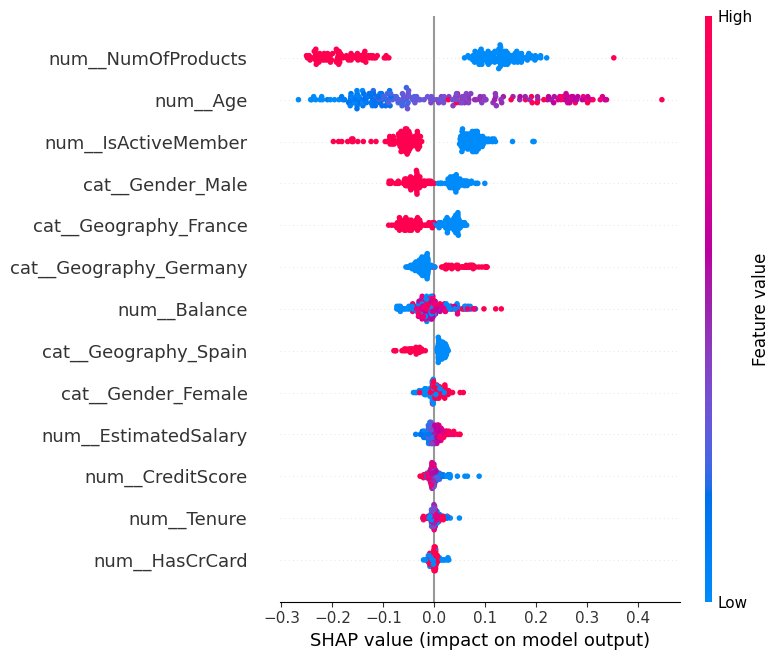

In [45]:
import shap

# wrap your model with a prediction function
explainer = shap.Explainer(best_model, X_train_proc)
shap_values = explainer(X_val_proc[:200])   # use a subset for speed

# summary plot (global feature importance)
shap.summary_plot(shap_values, X_val_proc[:200], feature_names=preprocessor.get_feature_names_out())


### Interpretation:
Number of products, Age, and Active membership are the 3 most importance contributors to churning from the bank.
- The blue (Low amount) is at a high SHAP value. This means that customers with low amount of products are more likely to churn.
- Customers usually with a higher age are more likely to churn as well
- Members with low activity are more likely to churn

Alongside these, categorical features like male, and countries like france, germany represent a 0 and 1 relationship as such that if it is 0 it means "not" france or "not" male. This means that gender wise, the churners are not male as the low side goes towards the higher shap value. This can be further confimed as from the female feature, it can be seen that the red high side is towards the positive shap value. Additionally, It can also be seen that members from germany also tend to churn and is a significant feature. 

Balance is a significant contributor, but the results are mixed mostly. This indicates that it may be related to another feature like the number of products or the member activity/age. Other minor features can also be seen such as estimated salary, customers with a higher salary tend to churn, alongside credit score, where customers with lower credit score also tend to churn more. Tenure and hascrcard also seem mixed, indicating interactions with other features.

Overall, the bank should convince customers to get more products, market more to customers of higher age, more female customers, and to customers in Germany.


### Potential Improvements
- The biggest improvement that could be made could be getting more into feature engineering, as it will help clear up variables like Balance and some others that may have interactions with other variables, going a step further into data preprocessing. 
- Additionally, outlier elimination can also be done as that could significantly affect the model and could potentially increase its accuracy/Recall/AUC. 
- Different activation functions for the NN can also be used such as LeakyRELU to get different results to compare. Overall, using KerasTuner was a good choice but trying out different NN structures alongside that could help it further potentially. 
- Regularization can also be taken into considerations to penalize high values to get a better generalization. 

Overall, the results were satisfactory. A few minor improvements can be made regarding feature engineering and further data cleaning alongside further testing the model. This can improve recall and significantly improve interpretability. 